In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [16]:
dataname = "m4_quarterly_id"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_quarterly_id.


In [17]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])


In [18]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='3M'),
 'item_id': 'Q1',
 'target': array([7407.412 , 7528.566 , 7374.709 , 7395.5146, 7654.008 , 7686.8477,
        7578.191 , 7904.3765, 7744.0493, 7889.909 , 7572.1113, 7526.693 ,
        7331.8457, 7433.141 , 7235.135 , 7278.0073, 6560.2314, 6958.5474,
        6635.4824, 6588.6646, 6679.074 , 6702.8555, 6636.5166, 6766.9473,
        6818.1665], dtype=float32),
 'feat_static_cat': array([1]),
 'source': SourceContext(source=Span(path=WindowsPath('C:/Users/TM/.mxnet/gluon-ts/datasets/m4_quarterly_id/train/m4_quarterly_id_train.json'), line=1), row=1)}

In [19]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='feat_static_cat' cardinality='24000'>]

In [20]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['24000']

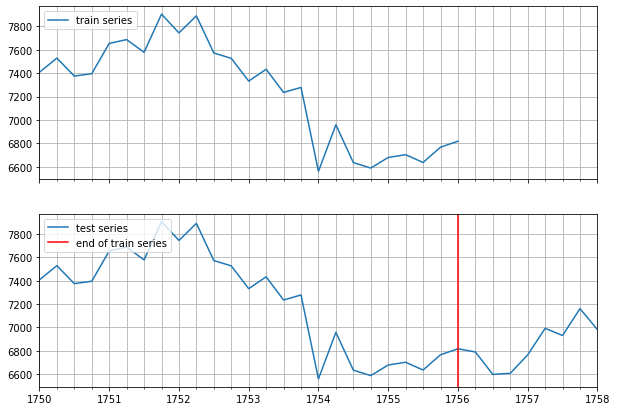

In [21]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [22]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

In [23]:
print(dataname)
epochs=500
num_batches = 100

mx.random.seed(42)
np.random.seed(42)

trainer = Trainer(
    ctx=mx.cpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
)

estimator = DeepAREstimator(
    trainer=trainer,
    cardinality= [
        feat_static_cat.cardinality 
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
#     context_length=dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True
)

predictor = estimator.train(training_data=dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

m4_quarterly_id


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.41it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 6.184 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.943439
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.94it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[1] Elapsed time 7.757 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.422727
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.56it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 8.657 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.147331
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.59it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[3] Elapsed time 6.030 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.224256
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.22it/s, avg_e

100%|██████████| 100/100 [00:05<00:00, 17.38it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[36] Elapsed time 5.757 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.593308
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 16.51it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 6.082 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.680851
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 12.66it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 7.911 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.792573
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 14.19it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[39] Elapsed time 7.058 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.410104
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.51it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[40] Elapsed time 6.900 se

INFO:root:Epoch[72] Elapsed time 7.913 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.656951
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 15.54it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[73] Elapsed time 6.441 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.760400
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 15.44it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[74] Elapsed time 6.498 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.632725
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:08<00:00, 11.71it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 8.562 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.553108
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:11<00:00,  8.47it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[76] Elapsed time 11.813 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.591

INFO:root:Epoch[108] Elapsed time 6.657 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.667927
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.39it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[109] Elapsed time 6.108 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.733406
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.91it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[110] Elapsed time 8.411 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.794713
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.57it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[111] Elapsed time 7.384 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.459923
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.02it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[112] Elapsed time 7.683 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.45it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[145] Elapsed time 6.079 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.553376
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.93it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[146] Elapsed time 5.914 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.700160
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.52it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[147] Elapsed time 6.443 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.488248
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.44it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[148] Elapsed time 6.100 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.636605
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.18it/s, avg_epoch_l

INFO:root:Epoch[181] Elapsed time 7.320 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=6.609892
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.66it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[182] Elapsed time 8.588 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.245935
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.38it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[183] Elapsed time 7.477 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.630534
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.97it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[184] Elapsed time 7.175 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.538686
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.55it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[185] Elapsed time 6.880 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.61

INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.68it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[218] Elapsed time 6.012 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=6.519656
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.20it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[219] Elapsed time 5.831 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.338801
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.91it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[220] Elapsed time 5.915 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.547491
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.68it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[221] Elapsed time 5.994 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.610438
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.87it/s, avg_epoch_

INFO:root:Epoch[254] Elapsed time 7.165 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=6.517322
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.09it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[255] Elapsed time 7.102 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.485500
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.60it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[256] Elapsed time 8.625 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.573025
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 11.08it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[257] Elapsed time 9.039 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.222421
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.05it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[258] Elapsed time 8.300 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.52

INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.06it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[291] Elapsed time 7.670 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=6.601990
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.51it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[292] Elapsed time 7.407 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.459375
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.50it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[293] Elapsed time 7.409 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.410810
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.23it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[294] Elapsed time 7.036 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.361132
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.49it/s, avg_epoch_l

INFO:root:Epoch[327] Elapsed time 6.769 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=6.382633
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.95it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[328] Elapsed time 10.065 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=6.521744
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.27it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[329] Elapsed time 9.744 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.509106
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.11it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[330] Elapsed time 7.637 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.406537
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 14.08it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[331] Elapsed time 7.106 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.5

INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 12.76it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[364] Elapsed time 7.837 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=6.388512
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.60it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[365] Elapsed time 6.442 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.526629
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.68it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[366] Elapsed time 6.019 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.528522
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.50it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[367] Elapsed time 6.069 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.428161
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.50it/s, avg_epoch_

INFO:root:Epoch[400] Elapsed time 6.459 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=6.354169
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.32it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[401] Elapsed time 6.145 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=6.489527
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.18it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[402] Elapsed time 6.187 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=6.424046
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.65it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[403] Elapsed time 6.008 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.590389
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.93it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[404] Elapsed time 5.926 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=6.42

INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.84it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[437] Elapsed time 5.959 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=6.184482
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.32it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[438] Elapsed time 6.132 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=6.431937
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.66it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[439] Elapsed time 6.006 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.510264
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.80it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[440] Elapsed time 5.972 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.356050
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.17it/s, avg_epoch_

INFO:root:Epoch[473] Elapsed time 8.105 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=6.362826
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.98it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[474] Elapsed time 5.903 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=6.337776
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.45it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[475] Elapsed time 6.476 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=6.368874
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.85it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[476] Elapsed time 6.317 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.408028
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 14.63it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[477] Elapsed time 6.838 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.500

In [24]:
metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

pd.DataFrame([output])

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9]
0,1.227869,0.104513,11.92698,0.097344,0.056164


In [25]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,Q1,28874.900391,1077.906250,54831.070312,6853.883789,308.422294,0.436863,0.019700,3.223509,750.737305,...,1077.906250,0.625,1078.445117,0.875,1253.347852,1.00,1218.534961,1.000,839.985840,1.0
1,Q2,49886.714844,1971.516113,56761.937500,7095.242188,357.911040,0.688550,0.034239,4.655105,872.082617,...,1971.516113,1.000,2186.578516,1.000,2184.696680,1.00,1758.536133,1.000,1211.916016,1.0
2,Q3,49530.015625,1619.329102,56761.523438,7095.190430,359.439593,0.563144,0.028184,3.317196,585.225391,...,1619.329102,1.000,2008.800781,1.000,2088.406934,1.00,1885.584961,1.000,1322.504883,1.0
3,Q4,31171.783203,1149.181152,61294.324219,7661.790527,317.977330,0.451754,0.018679,4.016552,522.089258,...,1149.181152,0.875,1229.894141,1.000,1240.996289,1.00,1127.385156,1.000,735.515723,1.0
4,Q5,27062.603516,1039.574219,9781.000000,1222.625000,149.800000,0.867468,0.101008,4.905796,623.820227,...,1039.574219,0.500,913.905615,0.625,948.423706,0.75,727.973145,0.875,552.001050,1.0


In [26]:
item_metrics.to_csv("m4_quarterly_id_deepar_metrics_owa0922.csv")